# Data Preparation and Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

import warnings
warnings.filterwarnings("ignore")

import pickle

import time

# utility functions, see utils.py
import utils

In [2]:
# Specify paths for data and figures 
DATA_PATH = "C:/dev/studienarbeit/ashrae-energy-prediction-data/csv"
PICKLE_PATH = "C:/dev/studienarbeit/ashrae-energy-prediction-data/pkl"
FIGURE_PATH = "C:/dev/studienarbeit/ashrae-energy-prediction-data/figures"

In [3]:
# Visualization parameters 

sns.set_theme(style="whitegrid", palette="Set2")

matplotlib.rcParams["backend"] = "pdf"
matplotlib.rcParams["figure.figsize"] = (10, 3)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.constrained_layout.use"] = "True"
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0
matplotlib.rcParams["savefig.directory"] = FIGURE_PATH
matplotlib.rcParams["savefig.format"] = "pdf"

## Construct dataframes
The method `load_data` will load and merge it with the respective weather and building data either the training or test set and reduce its memory size by changing the datatypes for each column (see utils.py) and return a dataframe. If `from_pickle` is True, we load the dataframe from a pickle file, which is faster.

In [4]:
train = utils.load_data(dataset='train', data_path=DATA_PATH, pickle_path=PICKLE_PATH, from_pickle=True, merge_weather_building=True, reduce_mem=True)
test = utils.load_data(dataset='test', data_path=DATA_PATH, pickle_path=PICKLE_PATH, from_pickle=True, merge_weather_building=True, reduce_mem=True)

print(f"Loading of dataframes complete.\nTrain shape: {train.shape}\nTest shape: {test.shape}")
print(f"Memory usage: {round(train.memory_usage().sum() / 1024**2, 2)} MB (train), {round(test.memory_usage().sum() / 1024**2, 2)} MB (test)")

Loading of dataframes complete.
Train shape: (20216100, 16)
Test shape: (41697600, 15)
Memory usage: 1041.1 MB (train), 1988.3 MB (test)


# Data Preparation
To prepare our data to be used by machine learning models, we will have to handle outliers and engineer some new features.

## Outliers
We remove outliers from our dataset as we already described in the notebook `01 Data Understanding`. We remove meter 2 (steam) of building 1099 and meter 0 (electricity) from buildings from site 0 because they use a different unit (see associated paper).

In [5]:
outlier_query = "not (((building_id == 1099) & (meter == 2)) or (building_id <= 104 & meter == 0 & timestamp <= '2016-05-20'))"
train = train.query(outlier_query)

## Feature Engineering

### Temporal features
We engineer new temporal features using built in functions from pandas. 
- day_of_week: Day of the week with Monday=0, ... Sunday=6
- day_of_year: Day of the year
- week_of_year: Week of the year
- month: Month with January=1, ..., December=12
- hour: Hours (0-24)
- day: Day (1-31)

We also engineer these features for the test set. Since this is just information depending on the timestamp already in the test set, we do not have to worry about data leakage and we can apply this feature engineering at this point.

In [6]:
def temporal_features(df):
    df["day_of_week"] = df["timestamp"].dt.dayofweek.astype(np.int8)
    df["day_of_year"] = df["timestamp"].dt.dayofyear.astype(np.int16)
    df["week_of_year"] = df["timestamp"].dt.isocalendar().week.astype(np.int8)

    df["month"] = df["timestamp"].dt.month.astype(np.int8)
    df["hour"] = df["timestamp"].dt.hour.astype(np.int8)
    df["day"] = df["timestamp"].dt.day.astype(np.int8)

temporal_features(train)
temporal_features(test)

### Building features
We also introduce the feature `building_age` so that we can model a relationship between the buildings age and its energy usage, which is possibly better described through the buildings age in years instead of the exact year the building was built.

In [7]:
train["building_age"] = 2017.0 - train["year_built"]
test["building_age"] = 2017.0 - test["year_built"]

### Weather features
To use the `wind_direction` features with is given in degrees (0-360) we will transform the wind direction into one of 16 wind direction categories (north, east, south, west, ...).

In [8]:
# Cutoff points between two directions. Calculated with 360/16=22.5, so North is 348.75 <= x < 11.25
angle = [11.25, 33.75, 56.25, 78.75, 101.25, 123.75, 146.25, 168.75, 191.25, 213.75, 236.25, 258.75, 281.25, 303.75, 326.25, 348.75]
direction = ['NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WMW', 'NW', 'NNW', 'N']

def construct_wind_dir(x):
    """Returns the wind direction given a compass direction (0-360)"""
    for i,a in enumerate(angle):
        if a <= x < a+22.5:
            return direction[i]
        
# For our calculation we add 360 degrees to wind directions less than 11.25
train["wind_direction"][train["wind_direction"] < 11.25] = train["wind_direction"][train["wind_direction"] < 11.25].apply(lambda x: x+360)
train["wind_direction"] = train["wind_direction"].apply(construct_wind_dir)

test["wind_direction"][test["wind_direction"] < 11.25] = test["wind_direction"][test["wind_direction"] < 11.25].apply(lambda x: x+360)
test["wind_direction"] = test["wind_direction"].apply(construct_wind_dir)

In [ ]:
# Use this cell only to import preprocessed dataframes from local pickle files
# with open("train_preprocessed.pkl", "wb") as f:
#     pickle.dump(train, f)
    
# with open("test_preprocessed.pkl", "wb") as f:
#     pickle.dump(test, f)
    
# with open("train_preprocessed.pkl", "rb") as f:
#     train = pickle.load(f)
    
# with open("test_preprocessed.pkl", "rb") as f:
#     test = pickle.load(f)

## Handle missing values
We now specify how we want preprocess each feature. We drop `timestamp` (not usable for our models), `meter_reading` (target variable) and `sea_level_pressure` and `wind_speed` because they are not significant. As described in the paper the two id features `building_id` and `site_id` should be treated as categories since the assigned ids are arbitrary numbers. Due to the described memory contrains when treating the id features as categories we chose to treat them as numerical values. Note that we ran some experiments and were able to train some models with the id features interpreted as categories and we achieved a lower error. 

In [9]:
# Specify column types
ids_categorical = {
    "drop_cols": ["timestamp", "meter_reading", "sea_level_pressure", "wind_speed"],
    "categorical_cols": ["meter", "primary_use", "day_of_week", "wind_direction", "site_id", "building_id"],
    "numerical_cols": ["square_feet", "year_built", "floor_count", "air_temperature", "cloud_coverage",
                        "dew_temperature", 'precip_depth_1_hr', "building_age",
                        "day_of_year", "week_of_year", "month", "hour", "day"],
}

ids_numerical = {
    "drop_cols": ["timestamp", "meter_reading", "sea_level_pressure", "wind_speed"],
    "categorical_cols": ["meter", "primary_use", "day_of_week", "wind_direction"],
    "numerical_cols": ["square_feet", "year_built", "floor_count", "air_temperature", "cloud_coverage",
                        "dew_temperature", 'precip_depth_1_hr', "building_age",
                        "day_of_year", "week_of_year", "month", "hour", "day", "site_id", "building_id"],
}

no_ids = {
    "drop_cols": ["timestamp", "meter_reading", "sea_level_pressure", "wind_speed", "site_id", "building_id"],
    "categorical_cols": ["meter", "primary_use", "day_of_week", "wind_direction"],
    "numerical_cols": ["square_feet", "year_built", "floor_count", "air_temperature", "cloud_coverage",
                        "dew_temperature", 'precip_depth_1_hr', "building_age",
                        "day_of_year", "week_of_year", "month", "hour", "day"],
}

In [10]:
# This is only needed to switch between ids_categorical, ids_numerical, and no_ids
category_dict = ids_numerical

In [11]:
# Split training dataset into target and features
y = train["meter_reading"]

# Drop target, timestamp and some features we will not explore
X = train.drop(category_dict["drop_cols"], axis = 1)

## Train-Validation Split
Our train data set will be split into a training and a validation set. Within the train_test_split we shuffle the dataset, so that our models have a chance to see all buildings.

In [12]:
from sklearn.model_selection import train_test_split

# Split Training set into train (75%) and validation (25%) dataset 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

## Preprocessing Pipeline
We use pipelines to make our preprocessing steps easily reusable across training runs. We define one preprocessing pipeline for categorical features (missing values are filled with most frequent value, encoded with One-Hot-Encoding) and one for numerical features (missing values are filled with the mean, scaled with the StandardScale). More info on what happens during preprocessing is available in the paper.

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Handle data based on their type
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse=True, handle_unknown="ignore"))
])

numerical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

In [14]:
from sklearn.compose import ColumnTransformer

# Preprocessing pipline ensures that the correct preprocessing pipelines get applied to their respective columns
preprocessing_pipeline = ColumnTransformer([
    ("categorical_preprocessor", categorical_pipeline, category_dict["categorical_cols"]),
    ("numerical_preprocessor", numerical_pipeline, category_dict["numerical_cols"])
])

# Models
At this point we import the mean_squared_log_error from Scikit-Learn which is our evaluation metric RMSLE when `squared=False`.

In [15]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_log_error

In [16]:
performance = []

## Linear Regression

While testing we have found that logarithmic transformation of the target variable during training significantly improves model accuracy. To achieve that we use the `TransformedTargetRegressor` class from scikit-learn which works as follows: <br>
- During `fit`: `regressor.fit(X, func(y))` (here we use `np.log1p` to compute the logarithm of the variable)<br>
- During `predict`: `inverse_func(regressor.predict(X))` (as the inverse we use `np.expm1`)

In [17]:
from sklearn.linear_model import LinearRegression

# Define Linear Regression model
lin_reg = LinearRegression()

# Define Transformed target regressor
trans_target_reg = TransformedTargetRegressor(regressor=lin_reg, func=np.log1p, inverse_func=np.expm1)

# Define Pipeline 
# 1. Preprocessing pipeline
# 2. Regressor 
linear_regression_pipeline = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("estimator", trans_target_reg)
])

t0 = time.time()
linear_regression_pipeline.fit(X_train, y_train)
t1 = time.time()

print(f"Fitted linear regression pipeline.")

Fitted linear regression pipeline.


We predict the meter reading of the validation set and compute the RMSLE. We save the model used, the training time and the RMSLE to compare the models later. For some models we found that there are predicted meter reading values that are negative. We know that the energy usage can not be negative and we therefore change all negative values to 0.

In [18]:
y_pred_lin_reg = linear_regression_pipeline.predict(X_val)

# Meter readings can not be negative
y_pred_lin_reg[y_pred_lin_reg < 0] = 0

rmsle = mean_squared_log_error(y_val, y_pred_lin_reg, squared=False)

# Save for evaluation
performance.append(["Linear Regression", t1-t0, rmsle])
print("Root mean squared logarithmic error:", rmsle)

Root mean squared logarithmic error: 1.8522547945972083


## Decision Tree

In [19]:
from sklearn.tree import DecisionTreeRegressor

# Define Linear Regression model
dt_reg = DecisionTreeRegressor(random_state=42, max_features="sqrt", max_depth=100)

# Define Transformed target regressor
trans_target_reg = TransformedTargetRegressor(regressor=dt_reg, func=np.log1p, inverse_func=np.expm1)

# Define Pipeline 
# 1. Preprocessing pipeline
# 2. Regressor 
dt_regression_pipeline = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("estimator", trans_target_reg)
])

t0 = time.time()
dt_regression_pipeline.fit(X_train, y_train)
t1 = time.time()
print(f"Fitted Decision Tree regression pipeline.")

Fitted Decision Tree regression pipeline.


In [20]:
y_pred_dt = dt_regression_pipeline.predict(X_val)

rmsle = mean_squared_log_error(y_val, y_pred_dt, squared=False)
performance.append(["Decision Tree", t1-t0, rmsle])
print(rmsle)

0.9661639905605514


## Random Forest

In [21]:
from sklearn.ensemble import RandomForestRegressor

# Define Linear Regression model
rf_reg = RandomForestRegressor(n_estimators=20, max_features="sqrt", max_depth=100, random_state=0, n_jobs=-1)

# Define Transformed target regressor
trans_target_reg = TransformedTargetRegressor(regressor=rf_reg, func=np.log1p, inverse_func=np.expm1)

# Define Pipeline 
# 1. Preprocessing pipeline
# 2. Regressor 
rf_regression_pipeline = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("estimator", trans_target_reg)
])

t0 = time.time()
rf_regression_pipeline.fit(X_train, y_train)
t1 = time.time()
print(f"Fitted Random Forest regression pipeline.")

Fitted Random Forest regression pipeline.


In [22]:
y_pred_rf = rf_regression_pipeline.predict(X_val)

rmsle = mean_squared_log_error(y_val, y_pred_rf, squared=False)
performance.append(["Random Forest", t1-t0, rmsle])
print(rmsle)

0.5859557970274709


## XGBoost

In [23]:
import xgboost as xgb

# Define XGBoost model
xgb_reg = xgb.XGBRegressor(colsample_bytree = 0.8, 
                           learning_rate = 0.1,
                           max_depth = 5)

# Define Transformed target regressor
trans_target_reg = TransformedTargetRegressor(regressor=xgb_reg, func=np.log1p, inverse_func=np.expm1)

# Define Pipeline 
# 1. Preprocessing pipeline
# 2. Regressor 
xgb_regression_pipeline = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("estimator", trans_target_reg)
])

t0 = time.time()
xgb_regression_pipeline.fit(X_train, y_train)
t1 = time.time()
print(f"Fitted XGBoost regression pipeline.")

Fitted XGBoost regression pipeline.


In [24]:
y_pred_xgb = xgb_regression_pipeline.predict(X_val)
y_pred_xgb[y_pred_xgb < 0] = 0

rmsle = mean_squared_log_error(y_val, y_pred_xgb, squared=False)
performance.append(["XGBoost", t1-t0, rmsle])
print(rmsle)

1.407517


In [24]:
performance

[['XGBoost', 943.0342485904694, 1.407517]]

## LightGBM Model

In [25]:
from lightgbm import LGBMRegressor

# Define LightGBM parameters
lgb_param = {
    'num_leaves': 512, 
    'learning_rate': 0.05,
    'min_data_in_leaf': 1000,
    'max_depth': -1, 
    'reg_lambda': 2,
    'objective': 'regression',
    'metric': 'rmse',
}

# Define LightGBM model
lgbm_reg = LGBMRegressor(**lgb_param)

# Define Transformed target regressor
trans_target_reg = TransformedTargetRegressor(regressor=lgbm_reg, func=np.log1p, inverse_func=np.expm1)

# Define Pipeline 
# 1. Preprocessing pipeline
# 2. Regressor 
lgbm_regression_pipeline = Pipeline([
    ("preprocessor", preprocessing_pipeline),
    ("estimator", trans_target_reg)
])

t0 = time.time()
lgbm_regression_pipeline.fit(X_train, y_train)
t1 = time.time()

print(f"Fitted LightGBM regression pipeline.")

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
Fitted LightGBM regression pipeline.


In [26]:
y_pred_lgb = lgbm_regression_pipeline.predict(X_val)
y_pred_lgb[y_pred_lgb < 0] = 0

rmsle = mean_squared_log_error(y_val, y_pred_lgb, squared=False)
performance.append(["LightGBM", t1-t0, rmsle])
print(rmsle)

0.8693494742859451


## Model Interpretation

### Feature Importance

The following functions `get_feature_out` and `get_ct_feature_names` are adapted from stack overflow user [Venkatachalam](https://stackoverflow.com/users/6347629/venkatachalam) to get the feature names from ColumnTransformer and subsequent Pipelines as seen here https://stackoverflow.com/a/57534118. Scikit-Learn has not yet implemented the `feature_names_in_` attribute for all sklearn estimators. The progress of this implementation can be followed here https://github.com/scikit-learn/scikit-learn/pull/13307/files.

In [28]:
from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.feature_selection._base import SelectorMixin

def get_feature_out(estimator, feature_in):
    if hasattr(estimator,'get_feature_names'):
        if isinstance(estimator, _VectorizerMixin):
            # handling all vectorizers
            return [f'vec_{f}' \
                for f in estimator.get_feature_names_out()]
        else:
            return estimator.get_feature_names_out(feature_in)
    elif isinstance(estimator, SelectorMixin):
        return np.array(feature_in)[estimator.get_support()]
    else:
        return feature_in


def get_ct_feature_names(ct):
    # handles all estimators, pipelines inside ColumnTransfomer
    # doesn't work when remainder =='passthrough'
    # which requires the input column names.
    output_features = []

    for name, estimator, features in ct.transformers_:
        if name!='remainder':
            if isinstance(estimator, Pipeline):
                current_features = features
                for step in estimator:
                    current_features = get_feature_out(step, current_features)
                features_out = current_features
            else:
                features_out = get_feature_out(estimator, features)
            output_features.extend(features_out)
        elif estimator=='passthrough':
            output_features.extend(ct._feature_names_in[features])
                
    return output_features

We retrieve the coefficients from the linear regression and the feature importances from all other models. Coefficients and feature importances show us which features had a big impact on the prediction for each model.

In [42]:
lreg_coef = pd.DataFrame({
    "feature_name": get_ct_feature_names(linear_regression_pipeline["preprocessor"]), 
    "coef": linear_regression_pipeline["estimator"].regressor_.coef_})

dtreg_fi = pd.DataFrame({
    "feature_name": get_ct_feature_names(dt_regression_pipeline["preprocessor"]), 
    "fi": dt_regression_pipeline["estimator"].regressor_.feature_importances_})

rfreg_fi = pd.DataFrame({
    "feature_name": get_ct_feature_names(rf_regression_pipeline["preprocessor"]), 
    "fi": rf_regression_pipeline["estimator"].regressor_.feature_importances_})

xgb_fi = pd.DataFrame({
    "feature_name": get_ct_feature_names(xgb_regression_pipeline["preprocessor"]), 
    "fi": xgb_regression_pipeline["estimator"].regressor_.feature_importances_})

lgbm_fi = pd.DataFrame({
    "feature_name": get_ct_feature_names(lgbm_regression_pipeline["preprocessor"]), 
    "fi": lgbm_regression_pipeline["estimator"].regressor_.feature_importances_})

We find that for all models but the baseline linear regression the `square_feet` feature is very important. The `building_id` and `site_id` is also important for most models as well as some temporal feature (`day_of_year`, `hour`) and the `meter`. All other features were not important to predict the meter reading.

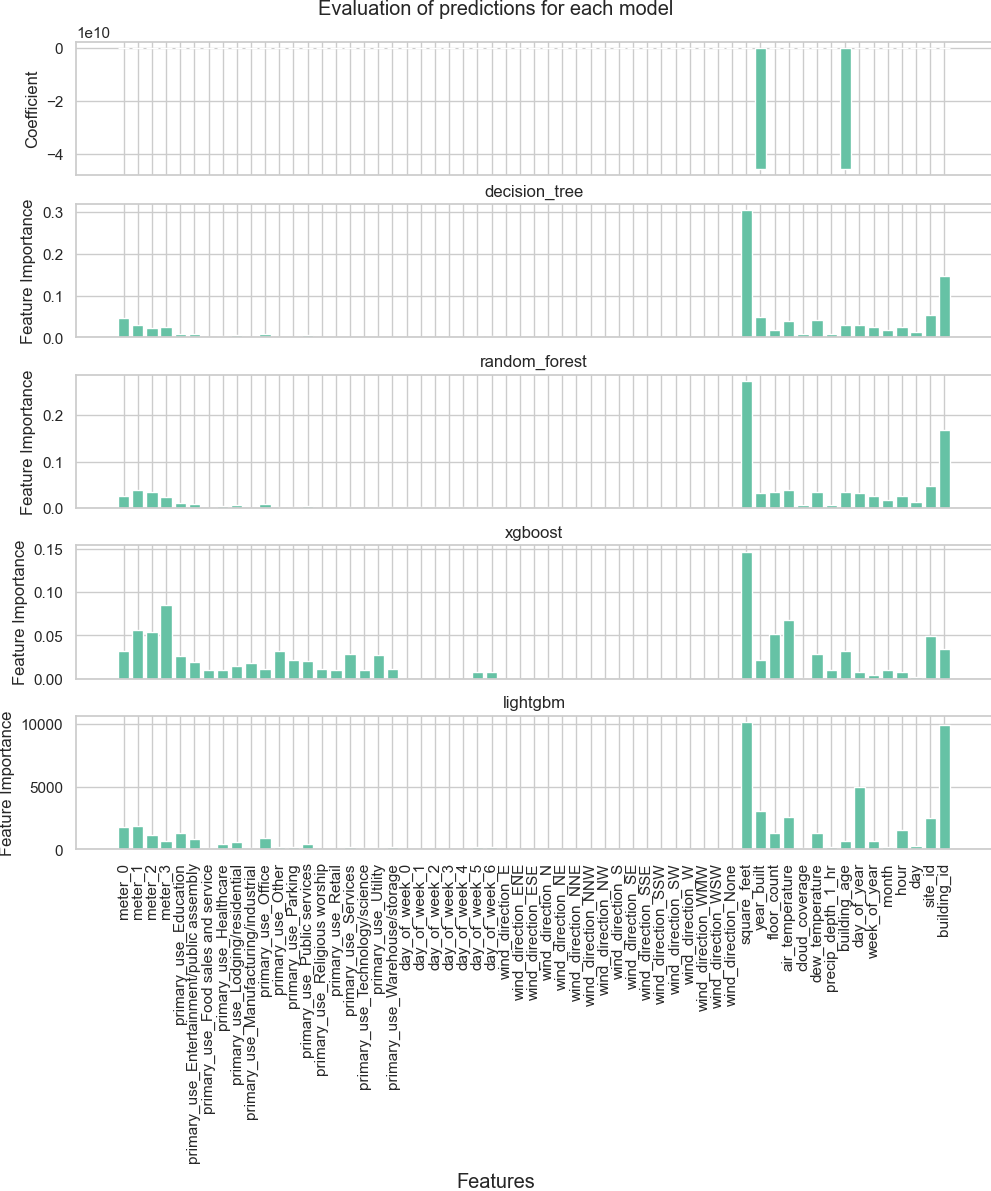

In [45]:
feature_importances = {
    "linear_regression": lreg_coef,
    "decision_tree": dtreg_fi,
    "random_forest": rfreg_fi,
    "xgboost": xgb_fi,
    "lightgbm": lgbm_fi
}

feature_names_plot = feature_importances["linear_regression"]["feature_name"]
fig, ax = plt.subplots(5, 1, figsize=(10,12), sharex=True)
ax[0].bar(feature_importances["linear_regression"]["feature_name"], feature_importances["linear_regression"]["coef"])
ax[0].set_ylabel("Coefficient")
ax[0].set_xticklabels(labels=feature_names_plot,rotation=90);

ax[1].bar(feature_importances["decision_tree"]["feature_name"], feature_importances["decision_tree"]["fi"])
ax[1].set_title("decision_tree")
ax[2].bar(feature_importances["random_forest"]["feature_name"], feature_importances["random_forest"]["fi"])
ax[2].set_title("random_forest")
ax[3].bar(feature_importances["xgboost"]["feature_name"], feature_importances["xgboost"]["fi"])
ax[3].set_title("xgboost")
ax[4].bar(feature_importances["lightgbm"]["feature_name"], feature_importances["lightgbm"]["fi"])
ax[4].set_title("lightgbm")

for i in [1,2,3,4]: 
    ax[i].set_ylabel("Feature Importance")
    ax[i].set_xticklabels(labels=feature_names_plot,rotation=90);
    
fig.supxlabel("Features")
fig.suptitle("Evaluation of predictions for each model")

plt.savefig(f"{FIGURE_PATH}/feature_importance")

Although our Decision Tree model performed worse than the ensemble methods the decision tree model has the advantage of explainability. Compared with the ensemble methods where we could only interpret the feature importance, the decision tree model can show us the actual tree which leads to a decision. Below we can see the tree up until a depth of 3 but it may still be interesting to see how the model makes a decision.

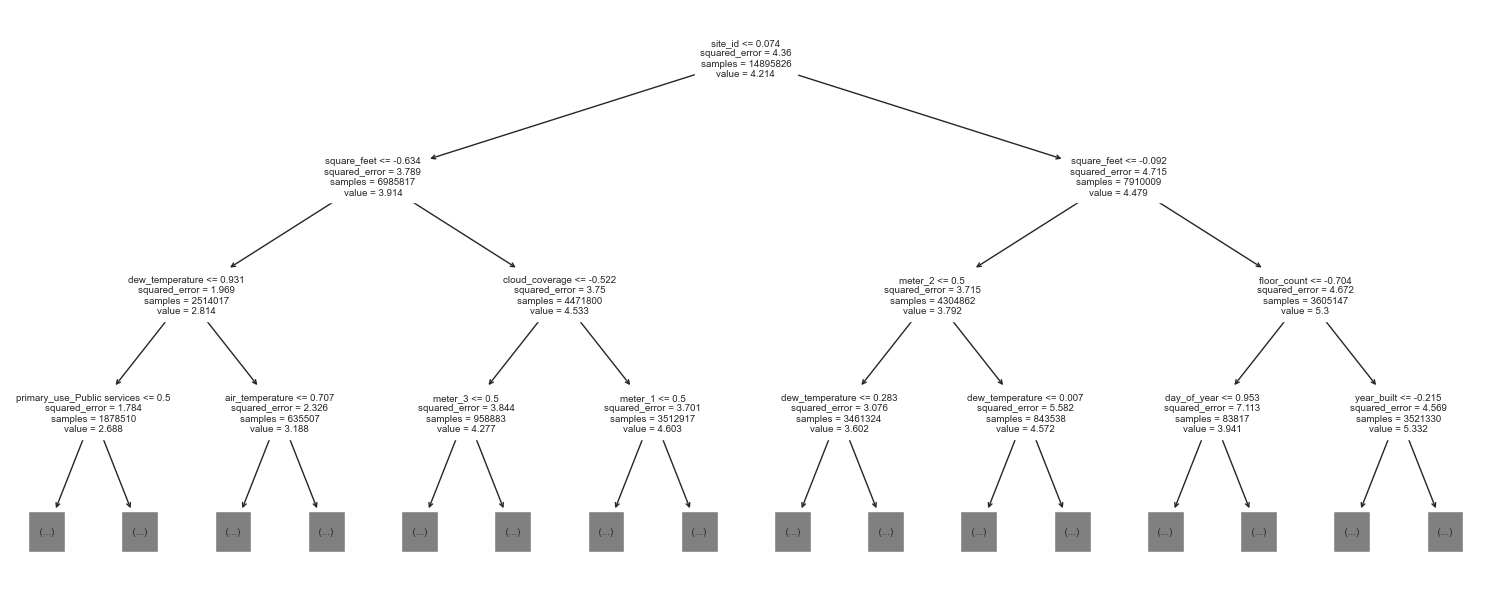

In [31]:
from sklearn import tree

decision_tree = dt_regression_pipeline["estimator"].regressor_
feature_names = get_ct_feature_names(dt_regression_pipeline["preprocessor"])

fig, ax = plt.subplots(1,1,figsize=(15,6))
tree.plot_tree(decision_tree, max_depth=3, feature_names=feature_names, fontsize=7, ax=ax)

plt.savefig(f"{FIGURE_PATH}/decision_tree")

# Plot prediction
We now plot the prediction from each model after a specified date. This is the actual version of what is only implemented as a dummy prototype in the web app. The specified date in this case is the date at which an energy conservation measure is implemented within a building and we can compare the actual energy usage with the predicted energy usage from our models. We see that the linear regression model can not model the complex relationship well. For the decision tree we see that the model predicts the energy usage well but also has a lot of outliers in both directions. The ensemble models resemble the overall trends of the energy usage but systematically predict lower values than the actual energy usage. This could be the case because we trained these models on a dataset with removed outliers.

In [40]:
models = {
    "linear_regression": linear_regression_pipeline,
    "decision_tree": dt_regression_pipeline,
    "random_forest": rf_regression_pipeline,
    "xgboost": xgb_regression_pipeline,
    "lightgbm": lgbm_regression_pipeline
    }

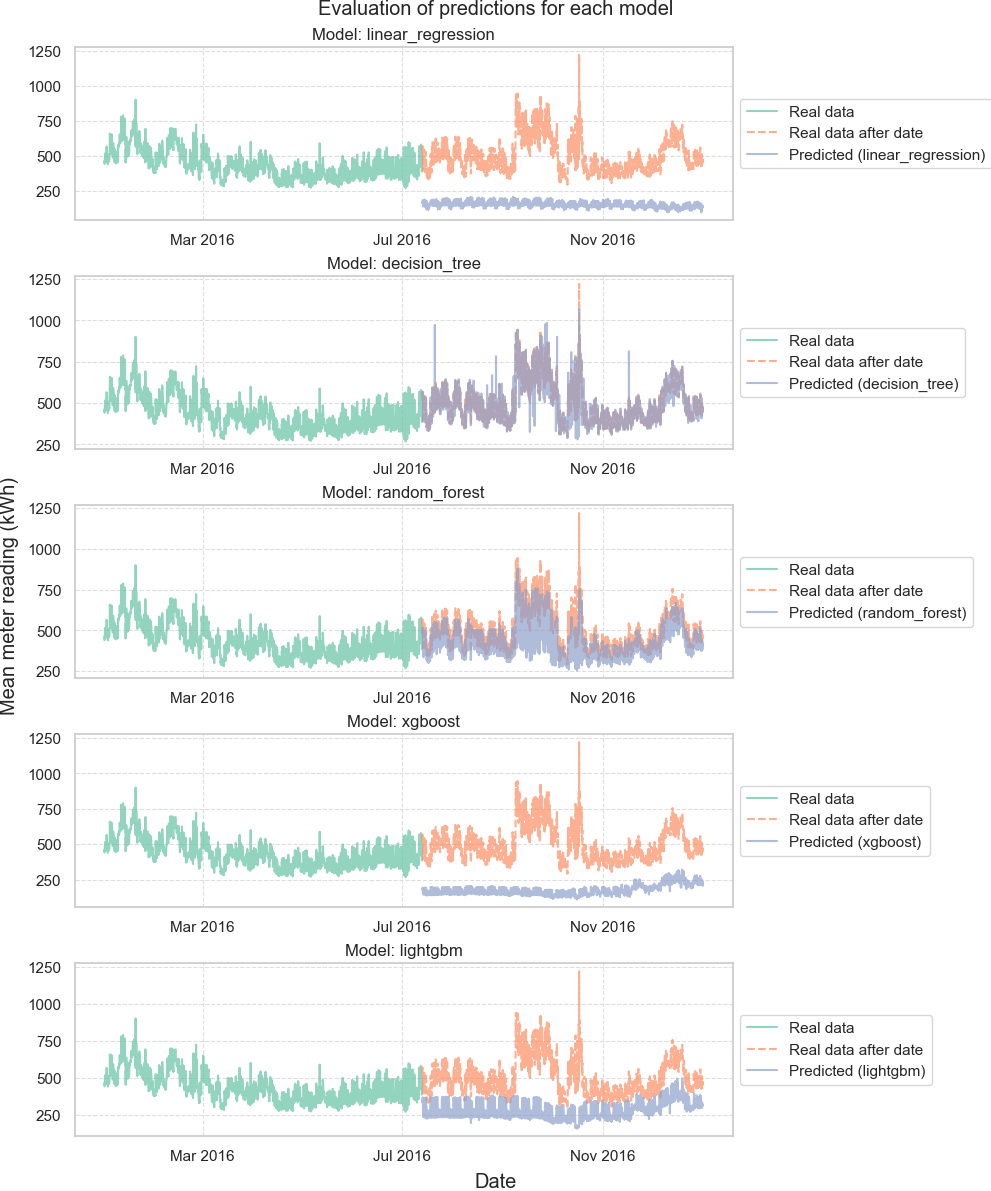

In [46]:
def show_prediction(models, date='2016-07-13 08:00'):
    """Makes plots for prediction of each model compared to actual meter reading after specified date"""
    
    # Train data before specified date
    train_show = train[train["timestamp"] < date]
    # Train data after specified date
    train_prediction_timeframe = train[train["timestamp"] >= date]
    
    # Save meter reading for timeframe that is to be predicted by models seperately
    y_real = train_prediction_timeframe["meter_reading"]
    train_prediction_timeframe.drop("meter_reading", axis=1, inplace=True)
    
    # Append a column of predicted meter readings for each model to train_prediction_timeframe
    for model in models:
        train_prediction_timeframe[model] = models[model].predict(train_prediction_timeframe)
    # Append actual meter reading to train_prediction_timeframe
    train_prediction_timeframe["meter_reading"] = y_real
    
    # Resample meter readings for train data before and after specified date, bc they are the same in each plot
    train_show_resampled = train_show[["timestamp", "meter_reading"]].set_index('timestamp').resample('H').mean()
    train_prediction_timeframe_resampled = train_prediction_timeframe[["timestamp", "meter_reading"]].set_index('timestamp').resample('H').mean()
    
    
    fig, ax = plt.subplots(5, 1, figsize=(10, 12))
    for i, model in enumerate(models):
        # ax_curr = [ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1]]
        ax_curr = ax
        # Real meter readings before and after specified date are plotted in each plot
        ax_curr[i].plot(train_show_resampled, alpha=0.7, label="Real data")
        ax_curr[i].plot(train_prediction_timeframe_resampled, alpha=0.7, label="Real data after date", linestyle="--")
        
        # Plot resampled meter reading of column for the given model
        ax_curr[i].plot(train_prediction_timeframe[["timestamp", model]].set_index('timestamp').resample('H').mean(), label=f"Predicted ({model})", alpha=0.7)
        
        ax_curr[i].set_title(f"Model: {model}")
        ax_curr[i].grid(which='major', color='#DDDDDD', linestyle='--', linewidth=0.8)
        ax_curr[i].xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=4)) 
        ax_curr[i].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %Y'))
        ax_curr[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))


    fig.supxlabel("Date")
    fig.supylabel("Mean meter reading (kWh)")
    fig.suptitle("Evaluation of predictions for each model")

        
show_prediction(models)
plt.savefig(f"{FIGURE_PATH}/evaluation")  

# Test set submissions
We now predict the test set with each of our models and submit them to the Kaggle competition for evaluation. The detailed evaluation and model comparison is available in the paper.

In [34]:
def make_submission(model, model_name):
    y_test_pred = model.predict(test).round(4)
    submission_df = pd.DataFrame({"row_id": test.index, "meter_reading": y_test_pred})
    submission_df.to_csv(f"{model_name}_submission.csv", index=False)

In [35]:
make_submission(linear_regression_pipeline, "linear_regression")
make_submission(dt_regression_pipeline, "decision_tree")
make_submission(rf_regression_pipeline, "random_forest")
make_submission(xgb_regression_pipeline, "xgboost")
make_submission(lgbm_regression_pipeline, "lightgbm")

## Export Models

In [36]:
# Save models as pickle file
with open("linear_regression_pipeline.pkl", "wb") as f:
    pickle.dump(linear_regression_pipeline, f)
    
with open("dt_regression_pipeline.pkl", "wb") as f:
    pickle.dump(dt_regression_pipeline, f)
    
with open("rf_regression_pipeline.pkl", "wb") as f:
    pickle.dump(rf_regression_pipeline, f)
    
with open("xgb_regression_pipeline.pkl", "wb") as f:
    pickle.dump(xgb_regression_pipeline, f)
    
with open("lgbm_regression_pipeline.pkl", "wb") as f:
    pickle.dump(lgbm_regression_pipeline, f)